In [1]:
from itertools import chain
import numpy as np
from midiutil import *
import pygame

import subprocess
from collections.abc import Sequence

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
working_pygame = False

track = 0
channel = 0
#pitch = 120
pitch = 60
pitch1 = 60
time = 0
duration = 1
volume = 100


In [3]:
def blank_midifile():
    MyMIDI = MIDIFile(1)
    return MyMIDI

#for i in range(12):
#    MyMIDI.addNote(track,channel,pitch+i,time+i,duration,volume)

In [4]:
if working_pygame:
    # mixer config
    freq = 44100  # audio CD quality
    bitsize = 16   # unsigned 16 bit
    channels = 2  # 1 is mono, 2 is stereo
    buffer = 1024   # number of samples
    pygame.mixer.init(freq, bitsize, channels, buffer)

    # optional volume 0 to 1.0
    pygame.mixer.music.set_volume(0.8)

    def play_music(midi_filename):
        '''Stream music_file in a blocking manner'''
        clock = pygame.time.Clock()
        pygame.mixer.music.load(midi_filename)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            clock.tick(30) # check if playback has finished
else:
    def play_music(midi_filename):
        subprocess.run(['timidity', midi_filename])

In [5]:
intervals = {'prim':0,
             'minor_second':1,
             'major_second':2,
             'minor_third':3,
             'major_third':4,
             'fourth':5,
             'tritone':6,
             'fifth':7,
             'minor_sixth':8,
             'major_sixth':9,
             'minor_seventh':10,
             'major_seventh':11,
             'octave':12
            }

In [52]:
class Scale(Sequence):
    def __init__(self, *constituents):
        super(Scale, self).__init__()
        self._list = constituents
        
    def __repr__(self):
        return f"<{self.__class__.__name__} {self._list}>"
    
    def __len__(self):
        return len(self._list)
    
    def __getitem__(self, ii):
        if isinstance(ii, int):
            relative_octave = 0
            while ii < 0:
                relative_octave -= 1
                ii += len(self)
            while len(self._list) <= ii:
                relative_octave += 1
                ii -= len(self)
            return self._list[ii] + 12 * relative_octave
        elif isinstance(ii, slice):
            if ii.start is None:
                ii = slice(0, ii.stop, ii.step)
            if ii.stop is None:
                ii = slice(ii.start, len(self), ii.step)
            output = []
            while ii.start < ii.stop:
                output.append(self[ii.start])
                ii = slice(ii.start+1, ii.stop, ii.step)
            return output
        else:
            raise TypeError("index must be int or slice")
    

In [53]:
major = [0, 2, 4, 5, 7, 9, 11] + [12 + x for x in [0, 2, 4, 5, 7, 9, 11]]
major_o = Scale(0, 2, 4, 5, 7, 9, 11)

print(len(major_o))

[major_o[x] for x in range(-5, 12)]

7


[-8, -7, -5, -3, -1, 0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19]

In [54]:
def major_chord(chord_numeral, jazzness=0):
    return major_o[chord_numeral-1:chord_numeral+jazzness+2:2]
major_chord(5, 2)

[7, 9, 11, 12, 14]

In [55]:
class Tone:
    def __init__(self, root, interval, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        if type(interval) == str:
            self.interval = intervals[interval]
        else:
            self.interval = interval
        self.duration = duration
        self.volume = volume
        
    #def __getattr__(self, name):
    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        midi_file.addNote(track, channel, self.root + self.interval, time, self.duration, self.volume)

In [56]:
class Chord:
    def __init__(self, root, constituents, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        self.constituents = []
        for interval in constituents:
            if type(interval) == str:
                self.constituents.append(intervals[interval])
            else:
                self.constituents.append(interval)
        self.duration = duration
        self.volume = volume

    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        for interval in self.constituents:
            midi_file.addNote(track, channel, self.root + interval, time, self.duration, self.volume)

In [57]:
#major_scale = np.array([0,2,4,5,7,9,11])
major_scale = np.array([0,2,4,5,7,9,11])

In [58]:
major_scale_probabilities = np.eye(12)[major_scale].sum(0)/7

In [59]:
melody = []
signs = []
rhythm = []
for _ in range(4):
    length = 0
    while length < 4:
        note = np.random.choice(range(0, 12), size = 1, p = major_scale_probabilities)
        #sign = np.random.choice([-1,1],size=1)
        sign = 1
        #duration = np.random.choice([0.25,0.5,1,1.25, 1.5, 1.75, 2], size=1)
        duration = np.random.choice([0.25,0.5,1, 2], size=1)
        melody.append(note)
        signs.append(sign)
        if duration > (4 - length):
            duration = 4 - length
        rhythm.append(duration)
        length += duration

In [60]:
length

array([4.])

In [61]:
melody = np.array(melody).flatten()
rhythm = np.array(rhythm).flatten()
signs = np.array(signs).flatten()

In [62]:
midi_file = blank_midifile()
the_lick = []
the_lick.append(Tone(pitch, 1, 0.5, time=0))
for interval, duration in [(2, 0.5), (3, 0.5), (5, 0.5), (2, 1), (-2, 0.5), (0, 1.5)]:
    the_lick.append(Tone(pitch, interval, duration, parent=the_lick[-1]))

for x in the_lick:
    x.add_note(midi_file, track, channel)

In [63]:
midi_file = blank_midifile()
midi_file.addProgramChange(track, channel+1, 0, 8)
random_music = []
pitches = melody*sign
random_music.append(Tone(60, pitches[0], rhythm[0], time=0))
for interval, duration in zip(pitches[1:], rhythm[1:]):
    random_music.append(Tone(pitch, interval, duration, parent=random_music[-1]))

for x in random_music:
    x.add_note(midi_file, track, channel)

In [64]:
#midi_file = blank_midifile()
c = Chord(pitch, major_chord(2, jazzness=1), duration=4)
d = Chord(pitch, major_chord(5, jazzness=1), duration=4, parent=c)
e = Chord(pitch, major_chord(1, jazzness=1), duration=4, parent=d)
f = Chord(pitch, major_chord(1, jazzness=1), duration=4, parent=e)
c.add_note(midi_file, track, channel+1)
d.add_note(midi_file, track, channel+1)
e.add_note(midi_file, track, channel+1)
f.add_note(midi_file, track, channel+1)

print(c.constituents)
print(d.constituents)
print(e.constituents)
print(f.constituents)

[2, 4, 5, 7]
[7, 9, 11, 12]
[0, 2, 4, 5]
[0, 2, 4, 5]


In [65]:
for midi_track in midi_file.tracks:
    midi_track.closeTrack()
with open('tmp.mid','wb') as f:
    midi_file.writeFile(f)

In [66]:
play_music('tmp.mid')

In [21]:
import matplotlib.pylab as plt

In [22]:
x = np.cumsum(rhythm)

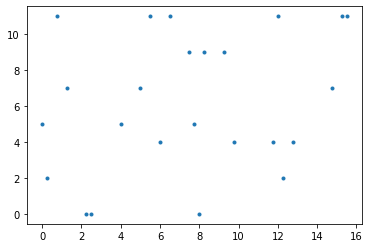

In [23]:
plt.plot([0] + list(x[:-1]), melody,'.')